In [51]:
pip install optuna joblib

# STEP 1: DATA LOADING & INITIAL ANALYSIS

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              VotingRegressor, StackingRegressor, ExtraTreesRegressor)
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.stats import normaltest, shapiro
import warnings
warnings.filterwarnings('ignore')

In [53]:
# Enhanced visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

In [54]:
print("CROP PRODUCTION PREDICTION SYSTEM")

CROP PRODUCTION PREDICTION SYSTEM


In [55]:
# Load data
df = pd.read_csv("/content/Crop_production1.csv" , engine="python", on_bad_lines="warn")

In [56]:
len(df)

99849

In [57]:
len(df.columns)

13

In [58]:
df.shape

(99849, 13)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99849 entries, 0 to 99848
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          99849 non-null  int64  
 1   State_Name          99849 non-null  object 
 2   Crop_Type           99849 non-null  object 
 3   Crop                99849 non-null  object 
 4   N                   99849 non-null  int64  
 5   P                   99849 non-null  int64  
 6   K                   99849 non-null  int64  
 7   pH                  99849 non-null  float64
 8   rainfall            99849 non-null  float64
 9   temperature         99849 non-null  float64
 10  Area_in_hectares    99849 non-null  float64
 11  Production_in_tons  99849 non-null  float64
 12  Yield_ton_per_hec   99849 non-null  float64
dtypes: float64(6), int64(4), object(3)
memory usage: 9.9+ MB


In [60]:
print("\n Missing Values Analysis:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values detected!")


 Missing Values Analysis:
No missing values detected!


In [61]:
df.head()

,Unnamed: 0,State_Name,Crop_Type,Crop,N,P,K,pH,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec
0,0,andhra pradesh,kharif,cotton,120,40,20,5.46,654.34,29.266667,7300.0,9400.0,1.287671
1,1,andhra pradesh,kharif,horsegram,20,60,20,6.18,654.34,29.266667,3300.0,1000.0,0.303030
2,2,andhra pradesh,kharif,jowar,80,40,40,5.42,654.34,29.266667,10100.0,10200.0,1.009901
3,3,andhra pradesh,kharif,maize,80,40,20,5.62,654.34,29.266667,2800.0,4900.0,1.750000
4,4,andhra pradesh,kharif,moong,20,40,20,5.68,654.34,29.266667,1300.0,500.0,0.384615


In [62]:
# Handle missing values by dropping rows with any missing values
print("\n Handling Missing Values...")
initial_rows = len(df)
df.dropna(inplace=True)
print(f"    Rows before handling missing values: {initial_rows:,}")
print(f"   Rows after handling missing values: {len(df):,}")
print(" Rows with missing values dropped.")



 Handling Missing Values...
    Rows before handling missing values: 99,849
   Rows after handling missing values: 99,849
 Rows with missing values dropped.


#STEP 2: COMPREHENSIVE EXPLORATORY DATA ANALYSIS


In [63]:
df.describe().round(2)

,Unnamed: 0,N,P,K,pH,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec
count,99849.00,99849.00,99849.00,99849.00,99849.00,99849.00,99849.00,99849.00,99849.00,99849.00
mean,49924.00,69.82,41.59,42.04,5.64,701.15,26.68,16476.59,37762.91,3.93
std,28824.07,39.57,15.06,28.43,0.51,604.70,4.85,43604.27,122244.67,33.87
min,0.00,10.00,10.00,10.00,3.82,3.27,1.18,0.58,0.00,0.00
25%,24962.00,50.00,40.00,20.00,5.36,157.31,23.11,130.00,162.00,0.59
50%,49924.00,75.00,40.00,30.00,5.54,579.75,27.33,1010.00,1506.00,1.33
75%,74886.00,80.00,60.00,50.00,5.96,1110.78,29.27,8099.00,14395.00,3.00
max,99848.00,180.00,125.00,200.00,7.00,3322.06,35.35,726300.00,3530571.00,9801.00


### Crop Type Distribution

In [64]:
print("\n Crop Type Distribution:")
crop_counts = df['Crop_Type'].value_counts()
crop_counts


 Crop Type Distribution:


,count
Crop_Type,
kharif,38758
rabi,27566
whole year,26448
summer,7077


####State-wise Analysis

In [65]:
print("\n State-wise Production Statistics:")
state_stats = df.groupby('State_Name').agg({
    'Production_in_tons': ['mean', 'sum', 'count'],
    'Area_in_hectares': 'mean',
    'Yield_ton_per_hec': 'mean'
}).round(2)
print(state_stats.head(10))


 State-wise Production Statistics:
                            Production_in_tons                      \
                                          mean           sum count   
State_Name                                                           
andaman and nicobar islands            3257.77  3.844167e+05   118   
andhra pradesh                        41663.48  1.584045e+08  3802   
arunachal pradesh                      3587.51  3.271814e+06   912   
assam                                 14997.13  8.285917e+07  5525   
bihar                                 20779.79  1.788725e+08  8608   
chandigarh                              870.02  5.481100e+04    63   
chhattisgarh                          17697.08  5.730316e+07  3238   
dadra and nagar haveli                 4945.39  4.055220e+05    82   
goa                                   19336.98  1.044197e+06    54   
gujarat                               70019.83  1.882133e+08  2688   

                            Area_in_hectares Yield_to

# Advanced Visualizations

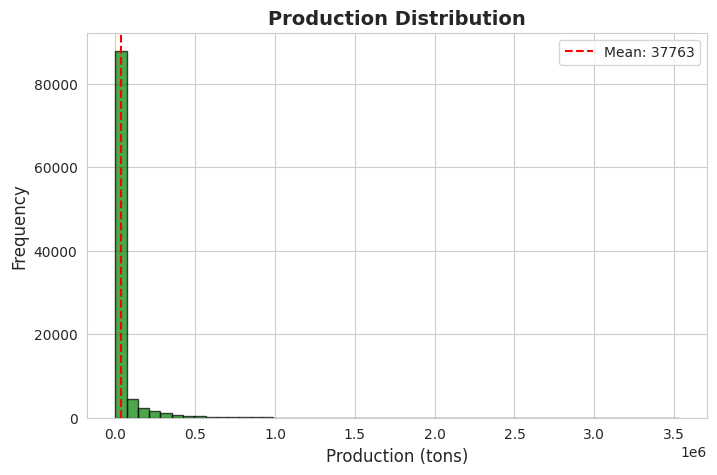

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df['Production_in_tons'], bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('Production Distribution', fontweight='bold')
plt.xlabel('Production (tons)')
plt.ylabel('Frequency')
plt.axvline(df['Production_in_tons'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["Production_in_tons"].mean():.0f}')
plt.legend()
plt.show()


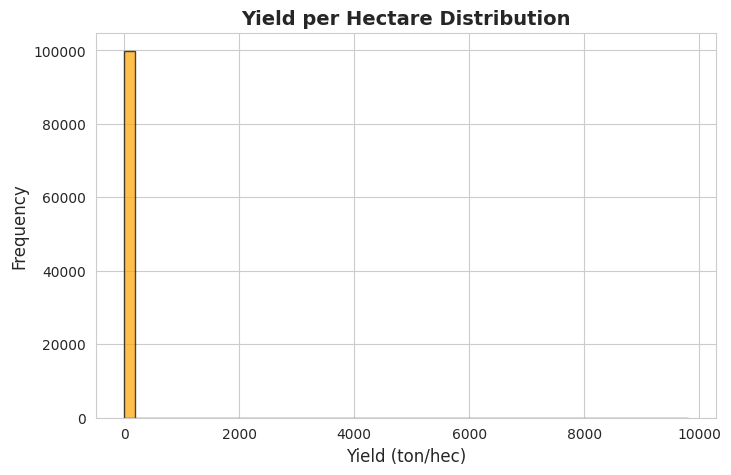

In [67]:
plt.figure(figsize=(8, 5))
plt.hist(df['Yield_ton_per_hec'], bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.title('Yield per Hectare Distribution', fontweight='bold')
plt.xlabel('Yield (ton/hec)')
plt.ylabel('Frequency')
plt.show()


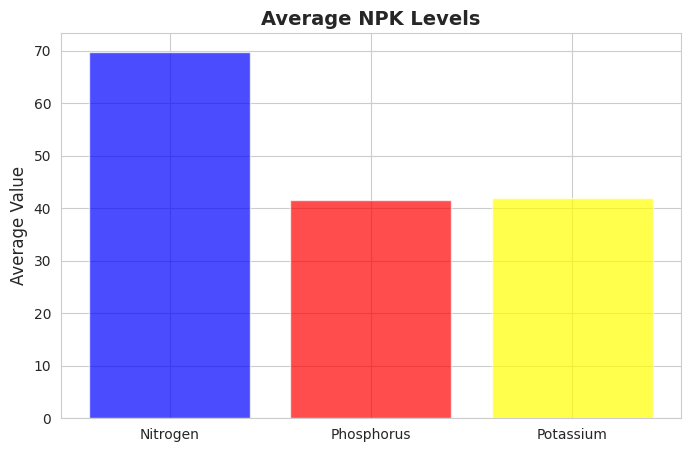

In [68]:
npk_data = df[['N', 'P', 'K']].mean()

plt.figure(figsize=(8, 5))
plt.bar(['Nitrogen', 'Phosphorus', 'Potassium'], npk_data, color=['blue', 'red', 'yellow'], alpha=0.7)
plt.title('Average NPK Levels', fontweight='bold')
plt.ylabel('Average Value')
plt.show()


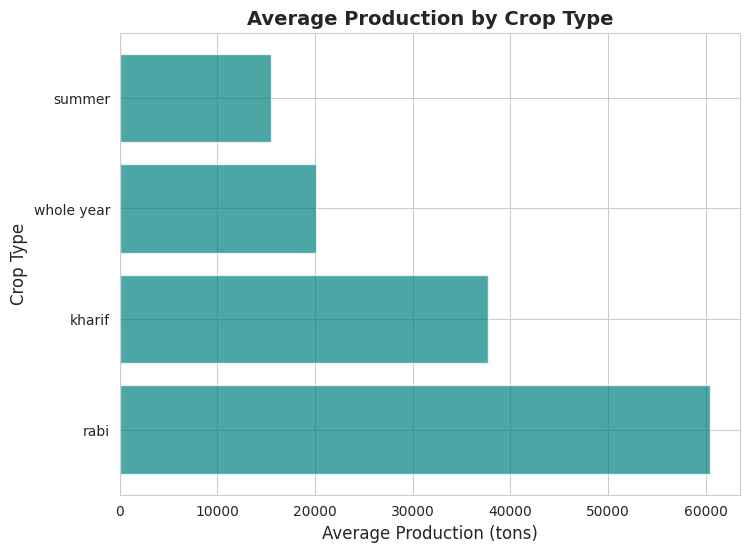

In [69]:
crop_prod = df.groupby('Crop_Type')['Production_in_tons'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(crop_prod.index, crop_prod.values, color='teal', alpha=0.7)
plt.title('Average Production by Crop Type', fontweight='bold')
plt.xlabel('Average Production (tons)')
plt.ylabel('Crop Type')
plt.show()


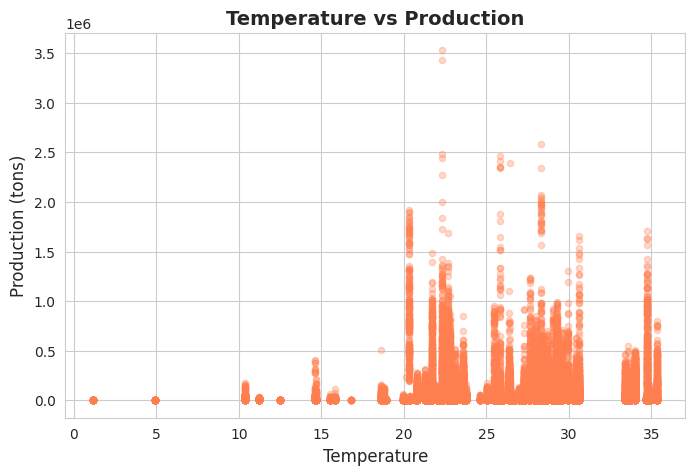

In [70]:
plt.figure(figsize=(8, 5))
plt.scatter(df['temperature'], df['Production_in_tons'], alpha=0.3, s=20, color='coral')
plt.title('Temperature vs Production', fontweight='bold')
plt.xlabel('Temperature')
plt.ylabel('Production (tons)')
plt.show()


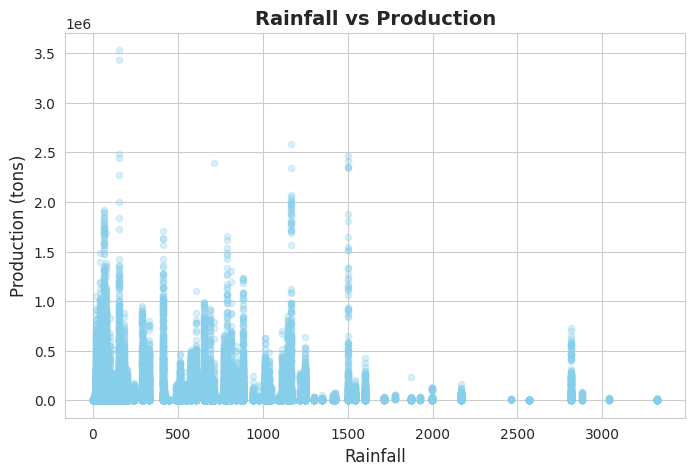

In [71]:
plt.figure(figsize=(8, 5))
plt.scatter(df['rainfall'], df['Production_in_tons'], alpha=0.3, s=20, color='skyblue')
plt.title('Rainfall vs Production', fontweight='bold')
plt.xlabel('Rainfall')
plt.ylabel('Production (tons)')
plt.show()


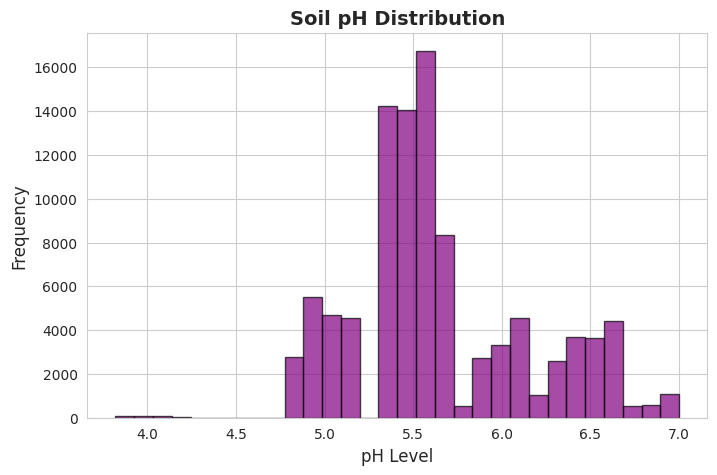

In [72]:
plt.figure(figsize=(8, 5))
plt.hist(df['pH'], bins=30, edgecolor='black', alpha=0.7, color='purple')
plt.title('Soil pH Distribution', fontweight='bold')
plt.xlabel('pH Level')
plt.ylabel('Frequency')
plt.show()


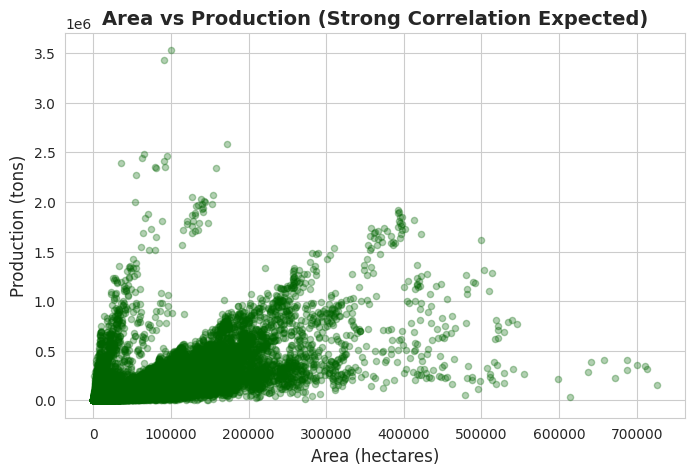

In [73]:
plt.figure(figsize=(8, 5))
plt.scatter(df['Area_in_hectares'], df['Production_in_tons'], alpha=0.3, s=20, color='darkgreen')
plt.title('Area vs Production (Strong Correlation Expected)', fontweight='bold')
plt.xlabel('Area (hectares)')
plt.ylabel('Production (tons)')
plt.show()


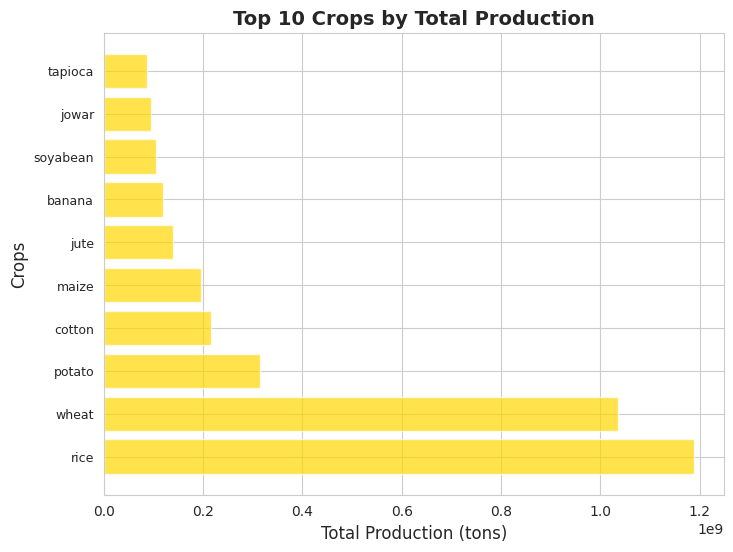

In [74]:
top_crops = df.groupby('Crop')['Production_in_tons'].sum().nlargest(10)

plt.figure(figsize=(8, 6))
plt.barh(range(len(top_crops)), top_crops.values, color='gold', alpha=0.7)
plt.yticks(range(len(top_crops)), top_crops.index, fontsize=9)
plt.title('Top 10 Crops by Total Production', fontweight='bold')
plt.xlabel('Total Production (tons)')
plt.ylabel('Crops')
plt.show()


In [75]:
# Correlation Analysis
print("\n Correlation Analysis:")
numerical_cols = ['N', 'P', 'K', 'pH', 'rainfall', 'temperature', 'Area_in_hectares',
                  'Production_in_tons', 'Yield_ton_per_hec']
corr_matrix = df[numerical_cols].corr()
print(corr_matrix['Production_in_tons'].sort_values(ascending=False))



 Correlation Analysis:
Production_in_tons    1.000000
Area_in_hectares      0.736019
N                     0.097888
pH                    0.073654
Yield_ton_per_hec     0.028306
P                    -0.010698
temperature          -0.023199
K                    -0.026379
rainfall             -0.097948
Name: Production_in_tons, dtype: float64


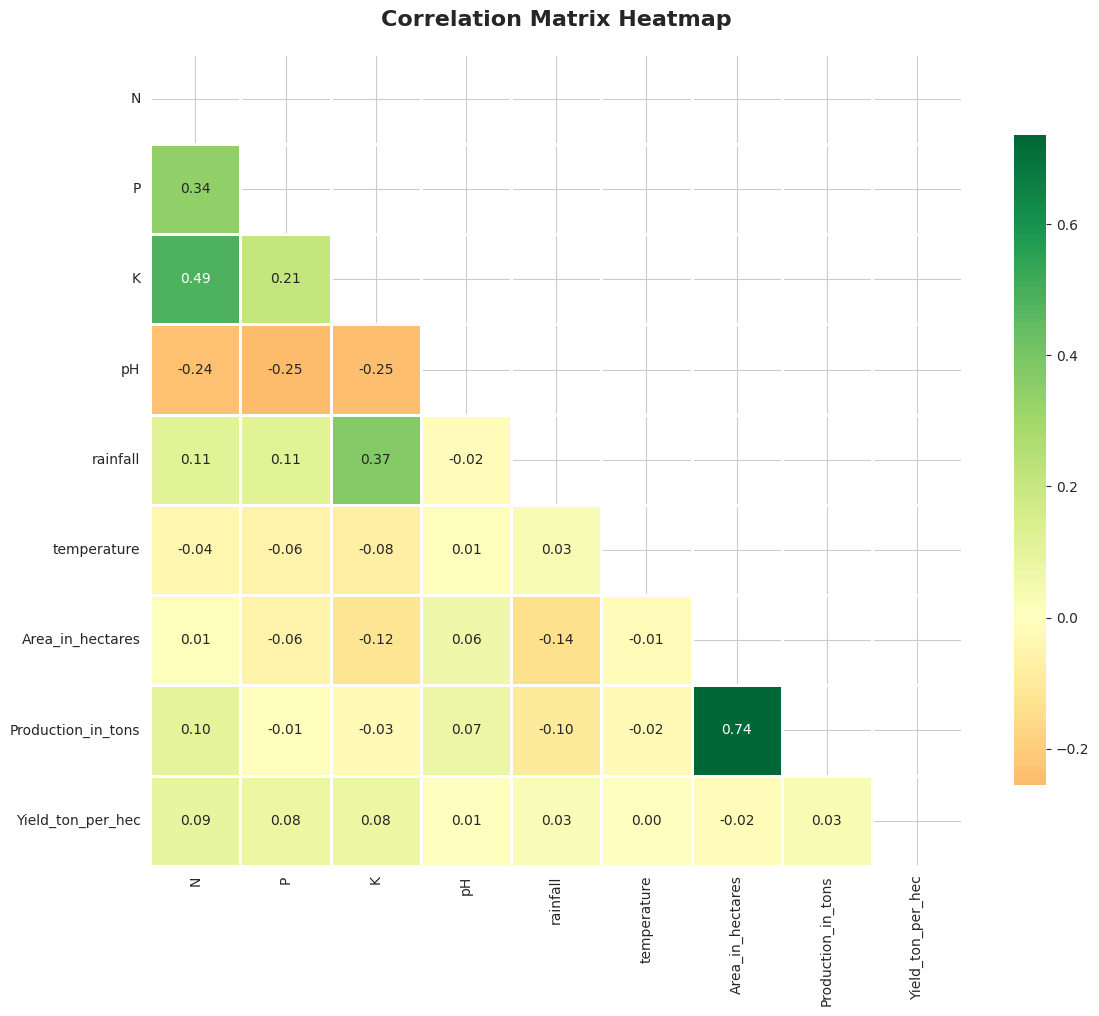

 EDA COMPLETE - READY FOR FEATURE ENGINEERING!


In [76]:
# Enhanced Correlation Heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

print(" EDA COMPLETE - READY FOR FEATURE ENGINEERING!")


# STEP 3: ADVANCED FEATURE ENGINEERING

In [77]:
df_processed = df.copy()

In [78]:
le_state = LabelEncoder()
le_crop = LabelEncoder()
le_crop_type = LabelEncoder()

In [79]:
# 1. NPK Features
df_processed['NPK_Total'] = df_processed['N'] + df_processed['P'] + df_processed['K']
df_processed['NPK_Ratio'] = df_processed['N'] / (df_processed['P'] + df_processed['K'] + 1)
df_processed['NP_Ratio'] = df_processed['N'] / (df_processed['P'] + 1)
df_processed['NK_Ratio'] = df_processed['N'] / (df_processed['K'] + 1)
df_processed['PK_Ratio'] = df_processed['P'] / (df_processed['K'] + 1)

# 2. Environmental Interactions
df_processed['Temp_Rainfall_Interaction'] = df_processed['temperature'] * df_processed['rainfall']
df_processed['Temp_pH_Interaction'] = df_processed['temperature'] * df_processed['pH']
df_processed['Rainfall_pH_Interaction'] = df_processed['rainfall'] * df_processed['pH']

# 3. Normalized Features
df_processed['pH_Normalized'] = (df_processed['pH'] - df_processed['pH'].mean()) / df_processed['pH'].std()
df_processed['Temp_Normalized'] = (df_processed['temperature'] - df_processed['temperature'].mean()) / df_processed['temperature'].std()
df_processed['Rainfall_Normalized'] = (df_processed['rainfall'] - df_processed['rainfall'].mean()) / df_processed['rainfall'].std()

# 4. Soil Nutrient Balance
df_processed['N_Dominance'] = df_processed['N'] / (df_processed['NPK_Total'] + 1)
df_processed['P_Dominance'] = df_processed['P'] / (df_processed['NPK_Total'] + 1)
df_processed['K_Dominance'] = df_processed['K'] / (df_processed['NPK_Total'] + 1)

# 5. Climate Severity Indicators
df_processed['Temp_Extremity'] = np.abs(df_processed['temperature'] - df_processed['temperature'].median())
df_processed['Rainfall_Extremity'] = np.abs(df_processed['rainfall'] - df_processed['rainfall'].median())

# 6. Productivity Indicators
df_processed['Area_Productivity'] = df_processed['Production_in_tons'] / (df_processed['Area_in_hectares'] + 1)
df_processed['Nutrient_Efficiency'] = df_processed['Production_in_tons'] / (df_processed['NPK_Total'] + 1)

# 7. Polynomial Features (key interactions)
df_processed['Area_Squared'] = df_processed['Area_in_hectares'] ** 2
df_processed['Temperature_Squared'] = df_processed['temperature'] ** 2
df_processed['Rainfall_Squared'] = df_processed['rainfall'] ** 2

# Apply Label Encoding
df_processed['State_Encoded'] = le_state.fit_transform(df_processed['State_Name'])
df_processed['Crop_Type_Encoded'] = le_crop_type.fit_transform(df_processed['Crop_Type'])
df_processed['Crop_Encoded'] = le_crop.fit_transform(df_processed['Crop'])

# Drop original categorical and 'Unnamed: 0' columns
df_processed.drop(columns=['State_Name', 'Crop_Type', 'Crop', 'Unnamed: 0'], inplace=True)

In [80]:
len(df_processed.columns)

33

# STEP 4: DATA PREPARATION & SPLITTING

In [81]:
feature_cols = [
    'N', 'P', 'K', 'pH', 'rainfall', 'temperature', 'Area_in_hectares',
    'State_Encoded', 'Crop_Type_Encoded', 'Crop_Encoded',
    'NPK_Total', 'NPK_Ratio', 'NP_Ratio', 'NK_Ratio', 'PK_Ratio',
    'Temp_Rainfall_Interaction', 'Temp_pH_Interaction', 'Rainfall_pH_Interaction',
    'pH_Normalized', 'Temp_Normalized', 'Rainfall_Normalized',
    'N_Dominance', 'P_Dominance', 'K_Dominance',
    'Temp_Extremity', 'Rainfall_Extremity',
    'Area_Productivity', 'Nutrient_Efficiency', 'Area_Squared', 'Temperature_Squared', 'Rainfall_Squared'
]

In [82]:
X = df_processed[feature_cols]
y = df_processed['Production_in_tons']

In [83]:
print(f"\n Feature Matrix Shape: {X.shape}")
print(f"Target Variable Shape: {y.shape}")
print(f"\n Target Statistics:")
print(f"    Mean: {y.mean():.2f}")
print(f"    Median: {y.median():.2f}")
print(f"    Std Dev: {y.std():.2f}")
print(f"    Min: {y.min():.2f}")
print(f"    Max: {y.max():.2f}")



 Feature Matrix Shape: (99849, 31)
Target Variable Shape: (99849,)

 Target Statistics:
    Mean: 37762.91
    Median: 1506.00
    Std Dev: 122244.67
    Min: 0.00
    Max: 3530571.00


In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [85]:
print(f"\n Data Split:")
print(f"   • Training Set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   • Test Set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")



 Data Split:
   • Training Set: 79,879 samples (80.0%)
   • Test Set: 19,970 samples (20.0%)


In [86]:
# Robust Scaling (better for outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 5: BASELINE MODELS

In [87]:
baseline_models = {}

In [88]:
# 1. Random Forest
print("\n Training Random Forest")
rf_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)
baseline_models['Random Forest'] = rf_base
print(" Completed!")

# 2. Gradient Boosting
print(" Training Gradient Boosting")
gb_base = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_base.fit(X_train, y_train)
baseline_models['Gradient Boosting'] = gb_base
print("  Completed!")

# 3. XGBoost
print("Training XGBoost")
xgb_base = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
xgb_base.fit(X_train, y_train)
baseline_models['XGBoost'] = xgb_base
print("Completed!")

# 4. LightGBM
print("Training LightGBM")
lgb_base = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
lgb_base.fit(X_train, y_train)
baseline_models['LightGBM'] = lgb_base
print("Completed!")

# 5. Extra Trees
print("Training Extra Trees")
et_base = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
et_base.fit(X_train, y_train)
baseline_models['Extra Trees'] = et_base
print(" Completed!")



 Training Random Forest
 Completed!
 Training Gradient Boosting
  Completed!
Training XGBoost
Completed!
Training LightGBM
Completed!
Training Extra Trees
 Completed!


In [89]:
print(" BASELINE MODEL PERFORMANCE")
baseline_metrics = {}
for name, model in baseline_models.items():
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    baseline_metrics[name] = {
        'MAE': mae, 'RMSE': rmse, 'R²': r2, 'MAPE': mape
    }

    print(f"\n{name}:")
    print(f"   MAE:  {mae:,.2f} tons")
    print(f"   RMSE: {rmse:,.2f} tons")
    print(f"   R²:   {r2:.4f}")
    print(f"   MAPE: {mape:.2f}%")

 BASELINE MODEL PERFORMANCE

Random Forest:
   MAE:  228.48 tons
   RMSE: 4,924.87 tons
   R²:   0.9983
   MAPE: 0.32%

Gradient Boosting:
   MAE:  1,544.87 tons
   RMSE: 5,260.17 tons
   R²:   0.9981
   MAPE: 4073182742472187392.00%

XGBoost:
   MAE:  1,181.31 tons
   RMSE: 7,235.26 tons
   R²:   0.9964
   MAPE: 417540824801756352.00%

LightGBM:
   MAE:  1,246.67 tons
   RMSE: 6,568.59 tons
   R²:   0.9970
   MAPE: 1444114894500064000.00%

Extra Trees:
   MAE:  117.10 tons
   RMSE: 1,577.42 tons
   R²:   0.9998
   MAPE: 51440714822394.27%


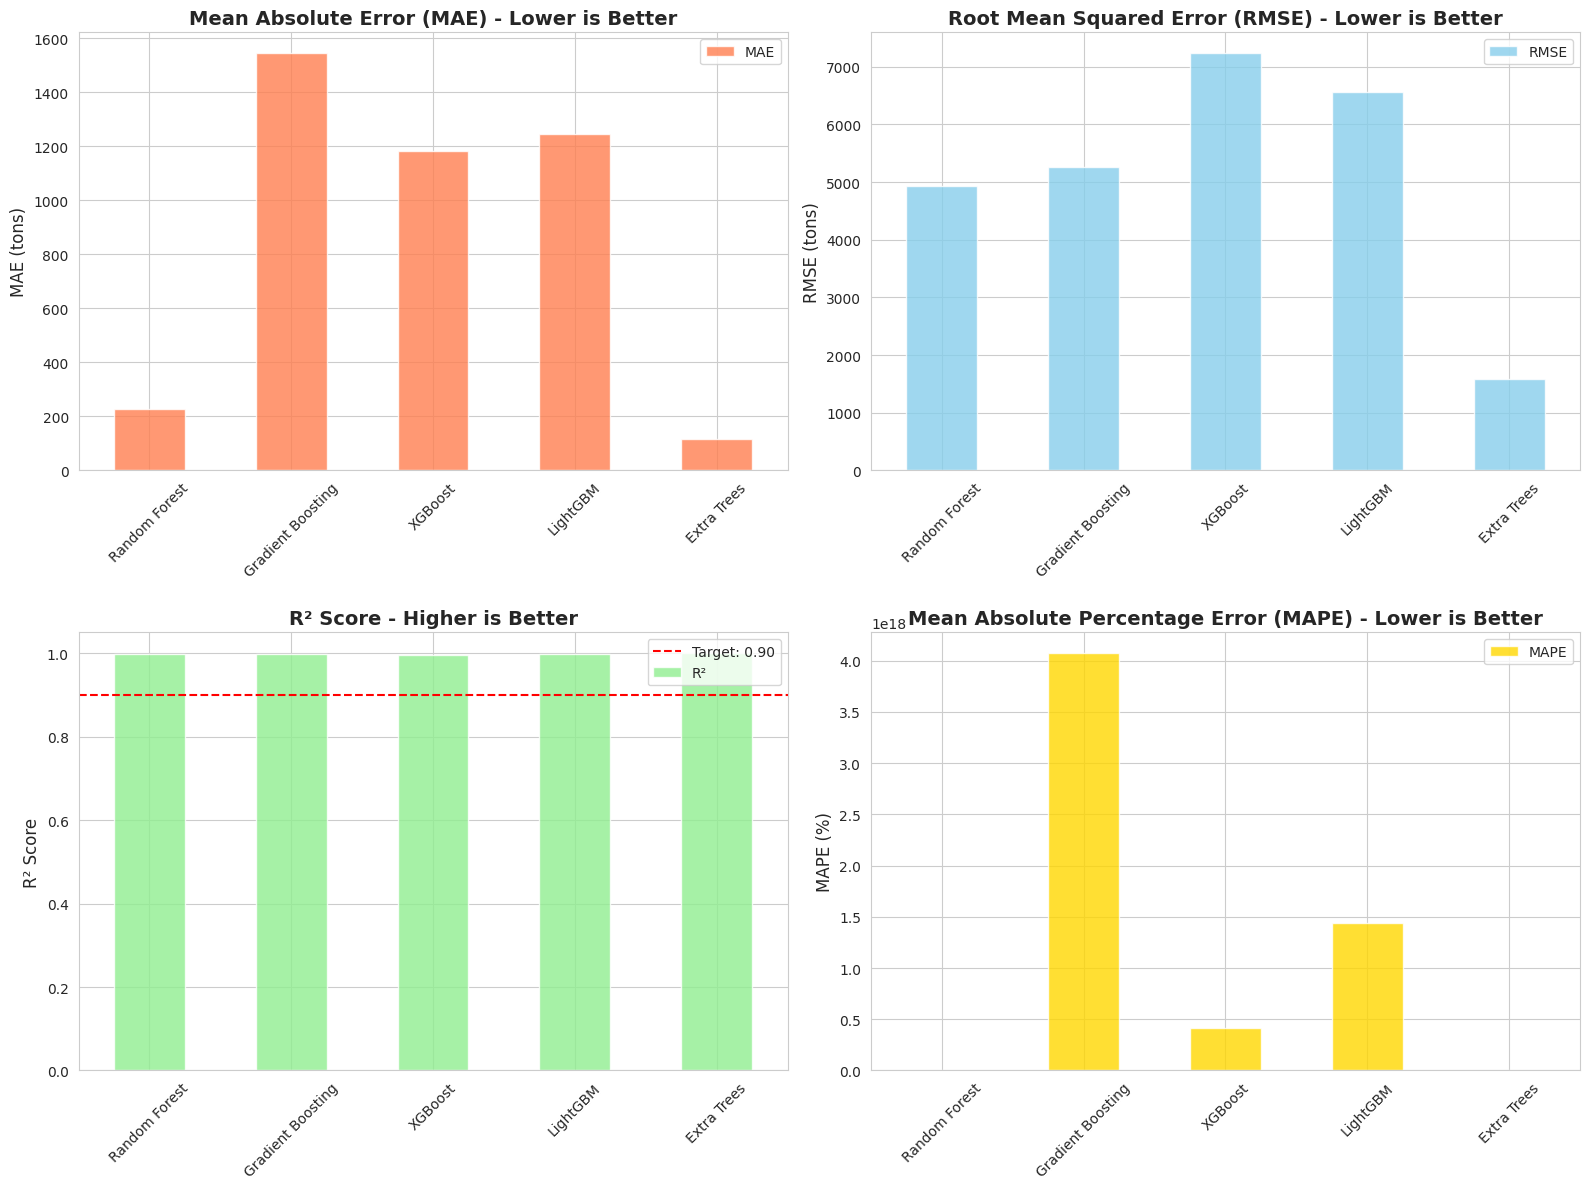


✅ Baseline models trained and evaluated successfully!
🏆 Best Baseline Model: Extra Trees


In [90]:
# 📊 Baseline Metrics Visualization
metrics_df = pd.DataFrame(baseline_metrics).T

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# MAE
metrics_df[['MAE']].plot(kind='bar', ax=axes[0, 0], color='coral', alpha=0.8)
axes[0, 0].set_title('Mean Absolute Error (MAE) - Lower is Better', fontweight='bold')
axes[0, 0].set_ylabel('MAE (tons)')
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE
metrics_df[['RMSE']].plot(kind='bar', ax=axes[0, 1], color='skyblue', alpha=0.8)
axes[0, 1].set_title('Root Mean Squared Error (RMSE) - Lower is Better', fontweight='bold')
axes[0, 1].set_ylabel('RMSE (tons)')
axes[0, 1].tick_params(axis='x', rotation=45)

# R²
metrics_df[['R²']].plot(kind='bar', ax=axes[1, 0], color='lightgreen', alpha=0.8)
axes[1, 0].set_title('R² Score - Higher is Better', fontweight='bold')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(y=0.9, color='red', linestyle='--', label='Target: 0.90')
axes[1, 0].legend()

# MAPE
metrics_df[['MAPE']].plot(kind='bar', ax=axes[1, 1], color='gold', alpha=0.8)
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE) - Lower is Better', fontweight='bold')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('baseline_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Baseline models trained and evaluated successfully!")
print(f"🏆 Best Baseline Model: {max(baseline_metrics, key=lambda k: baseline_metrics[k]['R²'])}")



TOP 15 FEATURE IMPORTANCE (Random Forest):
                Feature  Importance
    Nutrient_Efficiency    0.932781
              NPK_Total    0.033303
                      K    0.010542
               NP_Ratio    0.004598
      Area_Productivity    0.003370
                      N    0.003275
            P_Dominance    0.002538
                     pH    0.001307
           Crop_Encoded    0.001259
          pH_Normalized    0.000964
           Area_Squared    0.000719
Rainfall_pH_Interaction    0.000698
               PK_Ratio    0.000676
            N_Dominance    0.000646
       Area_in_hectares    0.000530


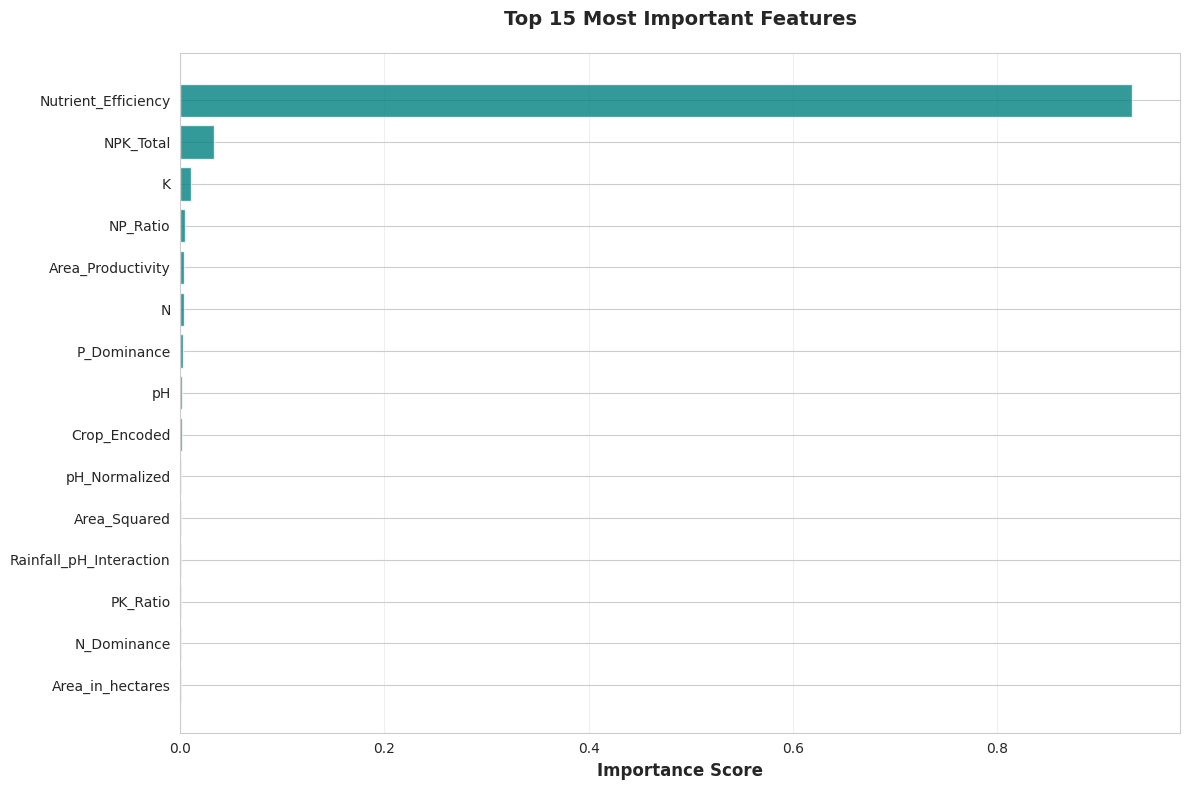


🎯 BASELINE ANALYSIS COMPLETE - READY FOR ADVANCED OPTIMIZATION!


In [91]:
# 🌾 Feature Importance (Random Forest)
print("\nTOP 15 FEATURE IMPORTANCE (Random Forest):")

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_base.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

print(feature_importance.to_string(index=False))

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], color='teal', alpha=0.8)
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Importance Score', fontweight='bold')
plt.title('Top 15 Most Important Features', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_top15.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎯 BASELINE ANALYSIS COMPLETE - READY FOR ADVANCED OPTIMIZATION!")


# STEP 6: HYPERPARAMETER OPTIMIZATION (Optuna)

In [92]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [93]:
optimized_models = {}

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**params)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()

print("\n Optimizing XGBoost ")
study_xgb = optuna.create_study(direction='maximize', study_name='XGBoost')
# Reduced n_trials for faster execution
study_xgb.optimize(objective_xgb, n_trials=5, show_progress_bar=False) # Reduced from 20 to 10 to 5

best_xgb = xgb.XGBRegressor(**study_xgb.best_params, random_state=42, n_jobs=-1, verbosity=0)
best_xgb.fit(X_train, y_train)
optimized_models['XGBoost_Optimized'] = best_xgb

print(f" XGBoost Optimized!")
print(f"   Best CV R² Score: {study_xgb.best_value:.4f}")
print(f"   Best Parameters: {study_xgb.best_params}")

# LightGBM Optimization
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    model = lgb.LGBMRegressor(**params)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()

print("\n💡 Optimizing LightGBM...")
study_lgb = optuna.create_study(direction='maximize', study_name='LightGBM')
# Reduced n_trials for faster execution
study_lgb.optimize(objective_lgb, n_trials=5, show_progress_bar=False) # Reduced from 20 to 10 to 5

best_lgb = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42, n_jobs=-1, verbose=-1)
best_lgb.fit(X_train, y_train)
optimized_models['LightGBM_Optimized'] = best_lgb

print(f" LightGBM Optimized!")
print(f"   Best CV R² Score: {study_lgb.best_value:.4f}")
print(f"   Best Parameters: {study_lgb.best_params}")


 Optimizing XGBoost 
 XGBoost Optimized!
   Best CV R² Score: 0.9942
   Best Parameters: {'n_estimators': 273, 'max_depth': 6, 'learning_rate': 0.24769880470126554, 'subsample': 0.7505297778644803, 'colsample_bytree': 0.9454145469917273, 'min_child_weight': 4, 'gamma': 0.24785368275258374, 'reg_alpha': 0.12759170108344386, 'reg_lambda': 0.4916815566555114}

💡 Optimizing LightGBM...
 LightGBM Optimized!
   Best CV R² Score: 0.9947
   Best Parameters: {'n_estimators': 472, 'max_depth': 4, 'learning_rate': 0.2911219560579893, 'num_leaves': 33, 'subsample': 0.7438147711675593, 'colsample_bytree': 0.7724773003300917, 'min_child_samples': 28, 'reg_alpha': 0.4790253020294061, 'reg_lambda': 0.953438930963557}


# STEP 7: ENSEMBLE METHODS

In [94]:
# 1. Voting Ensemble
print("\n 1)  Creating Voting Ensemble")
voting_reg = VotingRegressor(
    estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base),
        ('lgb', lgb_base),
        ('et', et_base)
    ],
    n_jobs=-1
)
voting_reg.fit(X_train, y_train)
optimized_models['Voting_Ensemble'] = voting_reg
print(" Voting Ensemble created!")


 1)  Creating Voting Ensemble
 Voting Ensemble created!


In [95]:
# 2. Stacking Ensemble
print("\n 2) Creating Stacking Ensemble...")
stacking_reg = StackingRegressor(
    estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base),
        ('lgb', lgb_base),
        ('et', et_base),
        ('gb', gb_base)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=3, # Reduced cross-validation splits for faster execution
    n_jobs=-1
)
stacking_reg.fit(X_train, y_train)
optimized_models['Stacking_Ensemble'] = stacking_reg
print(" Stacking Ensemble created!")


 2) Creating Stacking Ensemble...
 Stacking Ensemble created!


In [96]:
# 3. Deep Neural Network
print("\n 3) Training Deep Neural Network...")
dnn = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=300, # Reduced max_iter
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)
dnn.fit(X_train_scaled, y_train)
optimized_models['Deep_Neural_Network'] = dnn
print(" DNN trained!")


 3) Training Deep Neural Network...
 DNN trained!


# STEP 8: COMPREHENSIVE MODEL EVALUATION

In [97]:
final_metrics = {}

print("\n" + "-" * 100)
print(f"{'Model Name':<30} {'MAE':>12} {'RMSE':>12} {'R²':>10} {'MAPE':>10}")
print("-" * 100)

for name, model in optimized_models.items():
    # Use scaled data for DNN, regular data for others
    if name == 'Deep_Neural_Network':
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    final_metrics[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2, 'MAPE': mape}

    print(f"{name:<30} {mae:>12,.2f} {rmse:>12,.2f} {r2:>10.4f} {mape:>9.2f}%")



----------------------------------------------------------------------------------------------------
Model Name                              MAE         RMSE         R²       MAPE
----------------------------------------------------------------------------------------------------
XGBoost_Optimized                  1,291.52     7,402.28     0.9963 545560903292423488.00%
LightGBM_Optimized                 1,311.47     6,089.70     0.9975 1600868271166035712.00%
Voting_Ensemble                      538.12     3,637.26     0.9991 445296413095240000.00%
Stacking_Ensemble                    662.97     2,150.53     0.9997 1315594869900448512.00%
Deep_Neural_Network                  874.67     2,509.52     0.9996 3251663389858054144.00%


In [98]:
# Find best model
best_model_name = max(final_metrics, key=lambda k: final_metrics[k]['R²'])
print(f"\n BEST MODEL: {best_model_name}")
print(f"   R² Score: {final_metrics[best_model_name]['R²']:.4f}")
print(f"   MAE: {final_metrics[best_model_name]['MAE']:,.2f} tons")
print(f"   RMSE: {final_metrics[best_model_name]['RMSE']:,.2f} tons")


 BEST MODEL: Stacking_Ensemble
   R² Score: 0.9997
   MAE: 662.97 tons
   RMSE: 2,150.53 tons


# STEP 9: CROSS-VALIDATION ANALYSIS

In [99]:
cv_results = {}
# Reduced n_splits for faster execution
kfold = KFold(n_splits=3, shuffle=True, random_state=42) # Reduced from 5 to 3

print("\nPerforming 3-Fold Cross-Validation...")
for name, model in list(optimized_models.items())[:5]:  # Top 5 models
    if name != 'Deep_Neural_Network':  # Skip DNN for speed
        scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2', n_jobs=-1)
        cv_results[name] = scores
        print(f"\n{name}:")
        print(f"   Mean R²: {scores.mean():.4f} (±{scores.std():.4f})")
        print(f"   Scores: {[f'{s:.4f}' for s in scores]}")


Performing 3-Fold Cross-Validation...

XGBoost_Optimized:
   Mean R²: 0.9931 (±0.0026)
   Scores: ['0.9953', '0.9946', '0.9896']

LightGBM_Optimized:
   Mean R²: 0.9942 (±0.0011)
   Scores: ['0.9947', '0.9953', '0.9927']

Voting_Ensemble:
   Mean R²: 0.9972 (±0.0009)
   Scores: ['0.9978', '0.9979', '0.9959']

Stacking_Ensemble:
   Mean R²: 0.9989 (±0.0004)
   Scores: ['0.9992', '0.9991', '0.9983']


<Figure size 800x600 with 0 Axes>

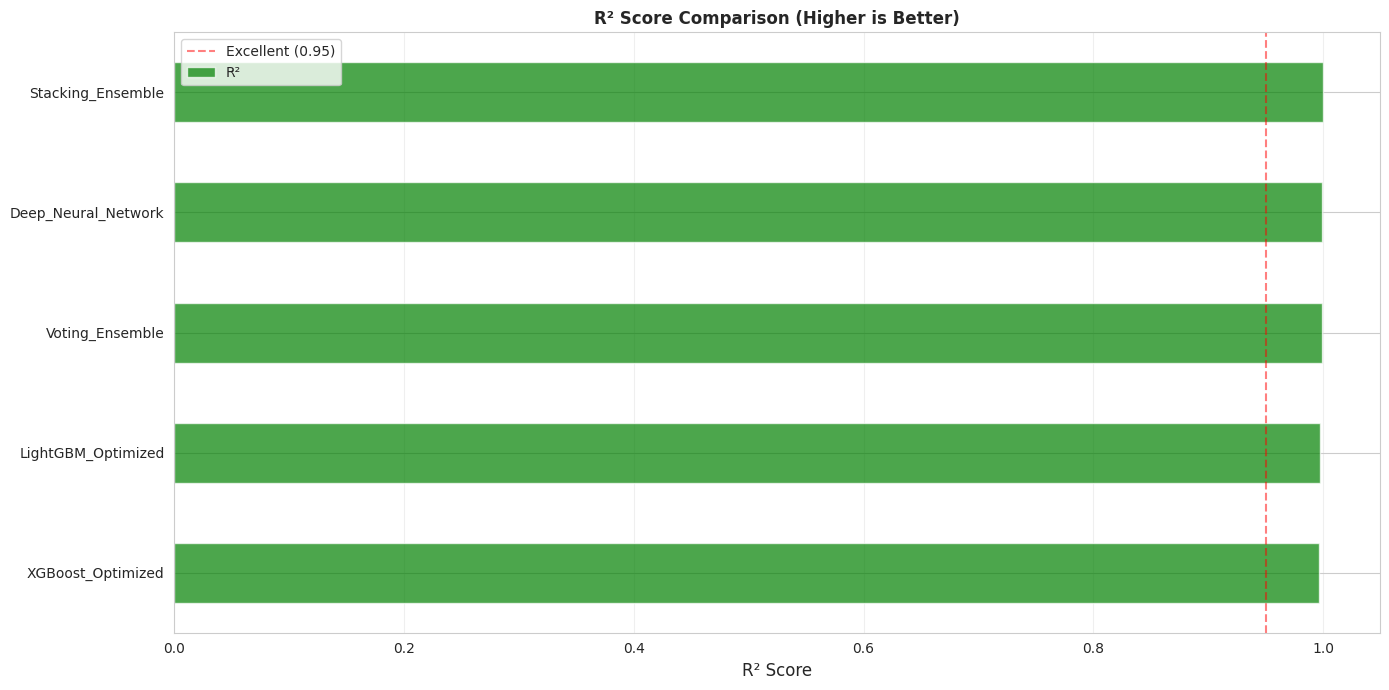

In [100]:
#  R² Score Comparison
metrics_df_final = pd.DataFrame(final_metrics).T

plt.figure(figsize=(8, 6))
metrics_df_final[['R²']].sort_values('R²', ascending=True).plot(kind='barh', color='green', alpha=0.7, legend=False)
plt.title('R² Score Comparison (Higher is Better)', fontweight='bold', fontsize=12)
plt.xlabel('R² Score')
plt.axvline(x=0.95, color='red', linestyle='--', alpha=0.5, label='Excellent (0.95)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('r2_score_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x600 with 0 Axes>

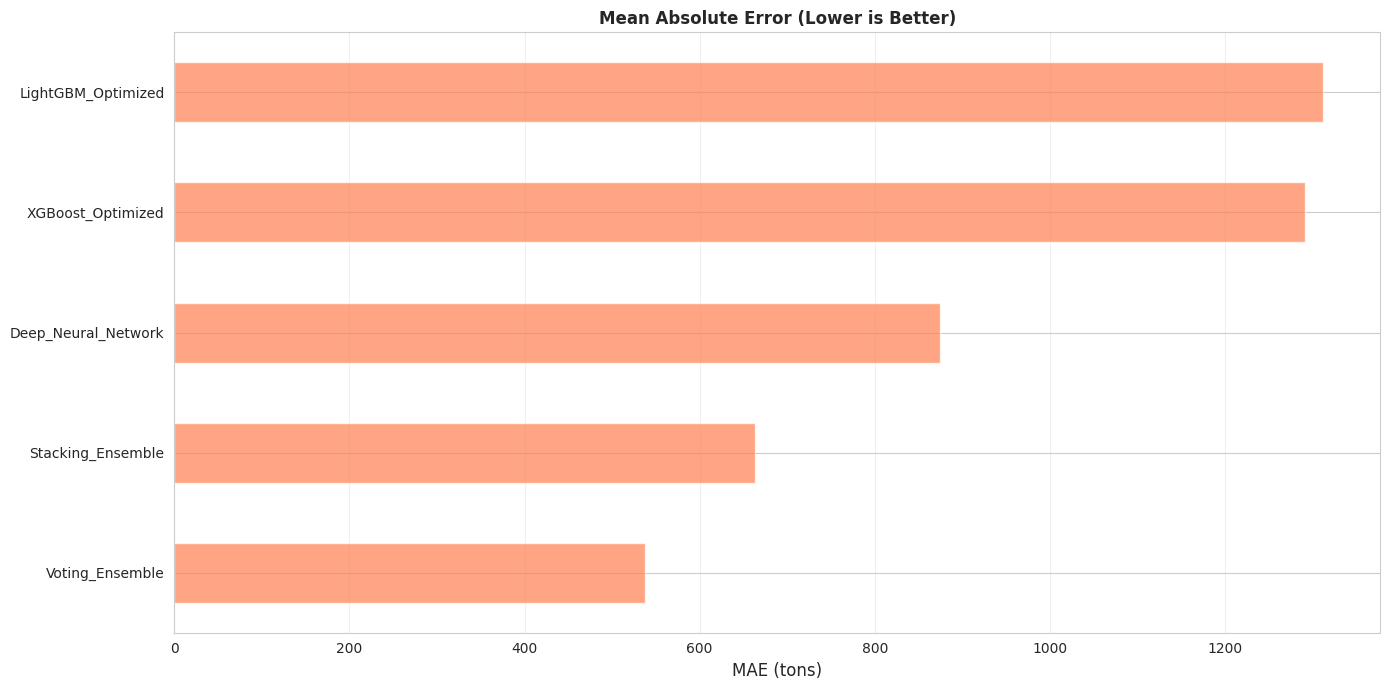

In [101]:
#  MAE Comparison
plt.figure(figsize=(8, 6))
metrics_df_final[['MAE']].sort_values('MAE').plot(kind='barh', color='coral', alpha=0.7, legend=False)
plt.title('Mean Absolute Error (Lower is Better)', fontweight='bold', fontsize=12)
plt.xlabel('MAE (tons)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('mae_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


<Figure size 800x600 with 0 Axes>

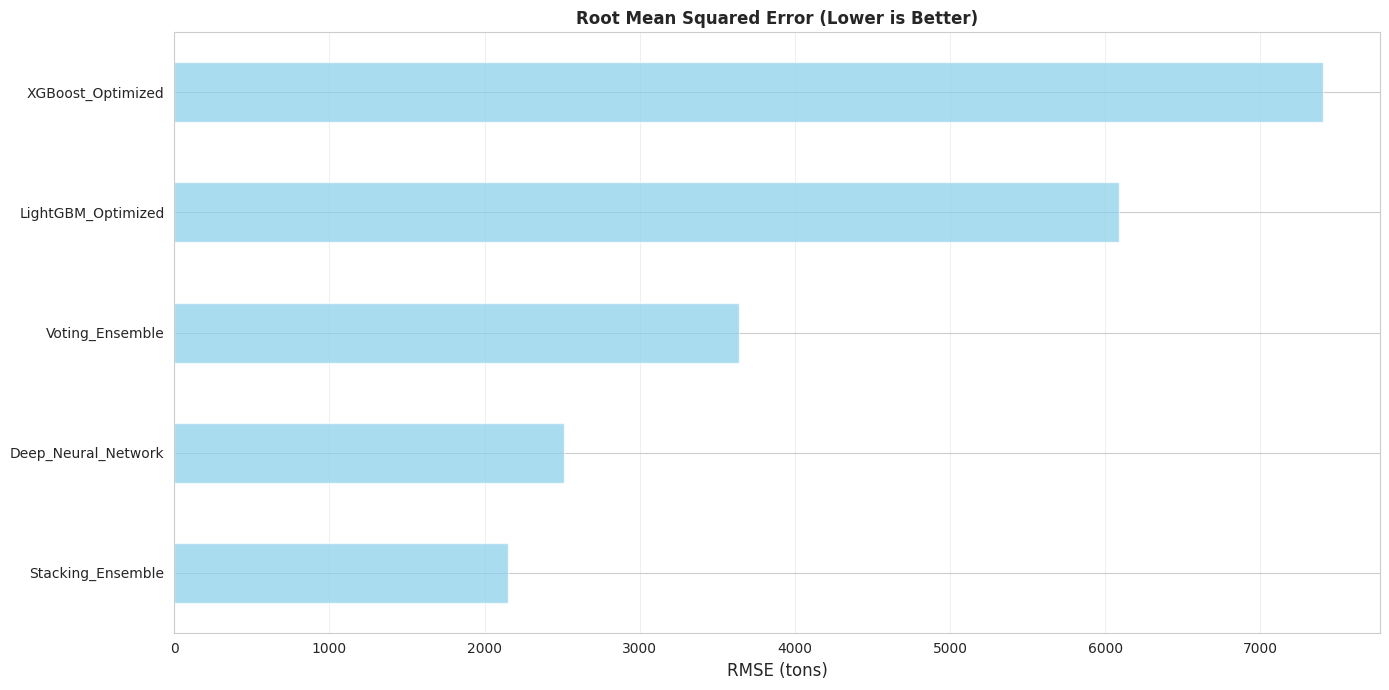

In [102]:
#  RMSE Comparison
plt.figure(figsize=(8, 6))
metrics_df_final[['RMSE']].sort_values('RMSE').plot(kind='barh', color='skyblue', alpha=0.7, legend=False)
plt.title('Root Mean Squared Error (Lower is Better)', fontweight='bold', fontsize=12)
plt.xlabel('RMSE (tons)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('rmse_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


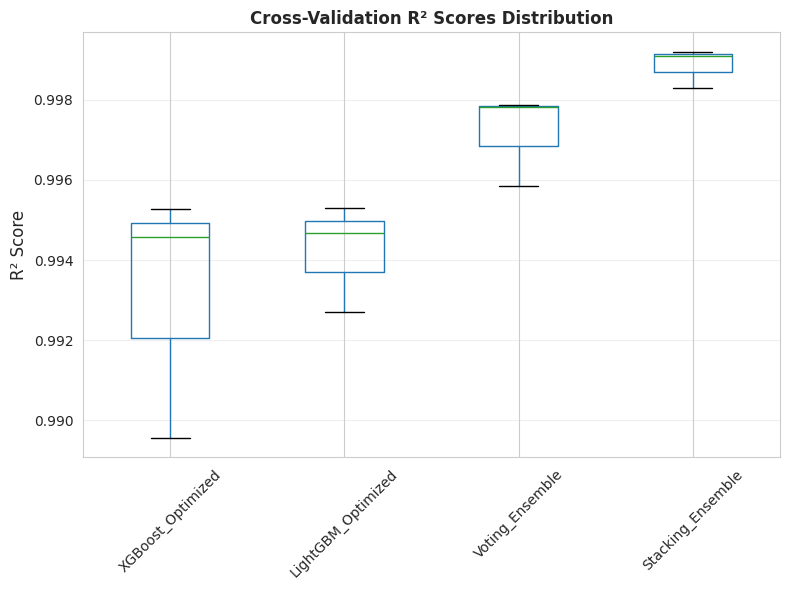

In [103]:
#  Cross-Validation R² Scores Distribution
if cv_results:
    plt.figure(figsize=(8, 6))
    cv_df = pd.DataFrame(cv_results)
    cv_df.boxplot()
    plt.title('Cross-Validation R² Scores Distribution', fontweight='bold', fontsize=12)
    plt.ylabel('R² Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('cv_r2_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


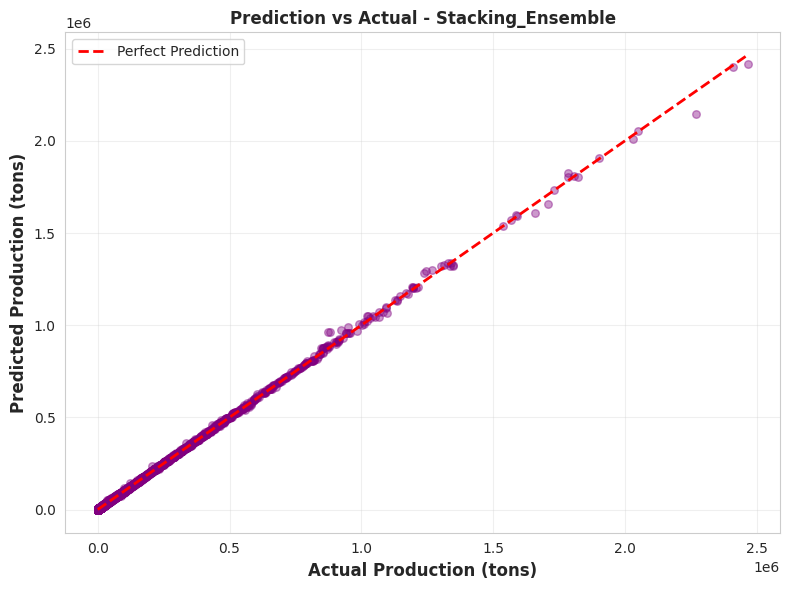

In [104]:
#  Prediction vs Actual (Best Model)
best_model = optimized_models[best_model_name]
if best_model_name == 'Deep_Neural_Network':
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.4, s=30, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Production (tons)', fontweight='bold')
plt.ylabel('Predicted Production (tons)', fontweight='bold')
plt.title(f'Prediction vs Actual - {best_model_name}', fontweight='bold', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()


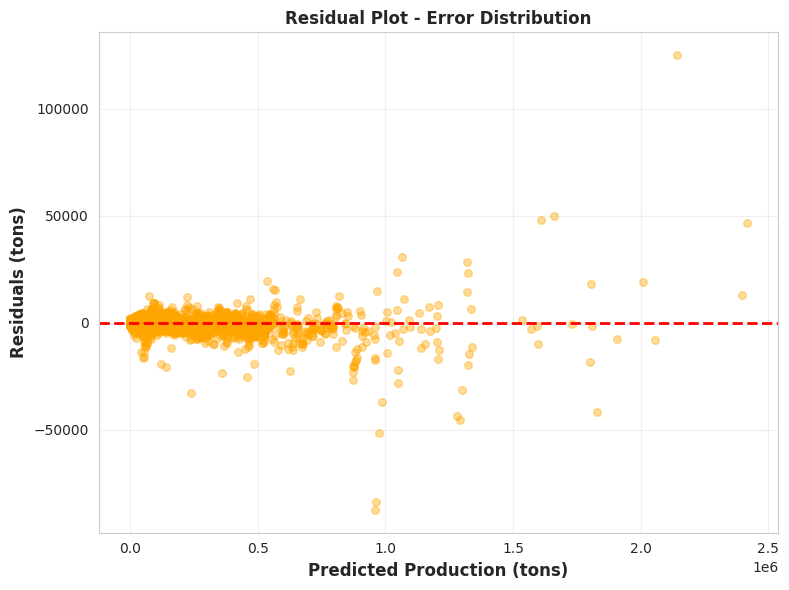

In [105]:
#  Residual Plot (Error Distribution)
residuals = y_test - y_pred_best

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_best, residuals, alpha=0.4, s=30, color='orange')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Production (tons)', fontweight='bold')
plt.ylabel('Residuals (tons)', fontweight='bold')
plt.title('Residual Plot - Error Distribution', fontweight='bold', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('residual_plot.png', dpi=300, bbox_inches='tight')
plt.show()


# STEP 10: FEATURE IMPORTANCE

In [106]:
# Get feature importance from best tree-based model
if best_model_name in ['XGBoost_Optimized', 'LightGBM_Optimized', 'Random Forest', 'Voting_Ensemble', 'Stacking_Ensemble', 'Extra Trees']: # Added ensemble models that might have feature importances
    # Check if the model has feature_importances_ attribute
    if hasattr(optimized_models[best_model_name], 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': optimized_models[best_model_name].feature_importances_
        }).sort_values('Importance', ascending=False)

        print("\n🔝 Top 20 Most Important Features:")
        print(feature_imp.head(20).to_string(index=False))

        # Visualize top features
        plt.figure(figsize=(14, 10))
        top_features = feature_imp.head(20)
        plt.barh(range(len(top_features)), top_features['Importance'], color='teal', alpha=0.8)
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Importance Score', fontweight='bold', fontsize=12)
        plt.title(f'Top 20 Feature Importance - {best_model_name}', fontweight='bold', fontsize=14, pad=20)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig('feature_importance_advanced.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print(f"\n⚠️  Feature importance not available for {best_model_name}")



⚠️  Feature importance not available for Stacking_Ensemble


# STEP 11: MODEL COMPARISON SUMMARY

In [107]:
#  Identify Best Baseline and Optimized Models
baseline_best = max(baseline_metrics, key=lambda k: baseline_metrics[k]['R²'])
optimized_best = max(final_metrics, key=lambda k: final_metrics[k]['R²'])

print(f"\nBaseline Best: {baseline_best}")
print(f"   R²: {baseline_metrics[baseline_best]['R²']:.4f}")
print(f"   MAE: {baseline_metrics[baseline_best]['MAE']:,.2f} tons")

print(f"\nOptimized Best: {optimized_best}")
print(f"   R²: {final_metrics[optimized_best]['R²']:.4f}")
print(f"   MAE: {final_metrics[optimized_best]['MAE']:,.2f} tons")



Baseline Best: Extra Trees
   R²: 0.9998
   MAE: 117.10 tons

Optimized Best: Stacking_Ensemble
   R²: 0.9997
   MAE: 662.97 tons


In [108]:
#  Calculate R² and MAE Improvement
r2_improvement = ((final_metrics[optimized_best]['R²'] - baseline_metrics[baseline_best]['R²']) /
                  baseline_metrics[baseline_best]['R²']) * 100

mae_improvement = ((baseline_metrics[baseline_best]['MAE'] - final_metrics[optimized_best]['MAE']) /
                   baseline_metrics[baseline_best]['MAE']) * 100

print(f"\n Performance Improvements:")
print(f"   R² Improvement: {r2_improvement:+.2f}%")
print(f"   MAE Improvement: {mae_improvement:+.2f}%")



 Performance Improvements:
   R² Improvement: -0.01%
   MAE Improvement: -466.16%


In [109]:
#  Combine Baseline and Optimized Model Metrics
all_models = {**baseline_metrics, **final_metrics}
all_metrics_df = pd.DataFrame(all_models).T
all_metrics_df.head()


,MAE,RMSE,R²,MAPE
Random Forest,228.482597,4924.871971,0.998340,3.174045e-01
Gradient Boosting,1544.868930,5260.172006,0.998107,4.073183e+18
XGBoost,1181.307948,7235.264132,0.996418,4.175408e+17
LightGBM,1246.670088,6568.593033,0.997047,1.444115e+18
Extra Trees,117.100199,1577.418286,0.999830,5.144071e+13


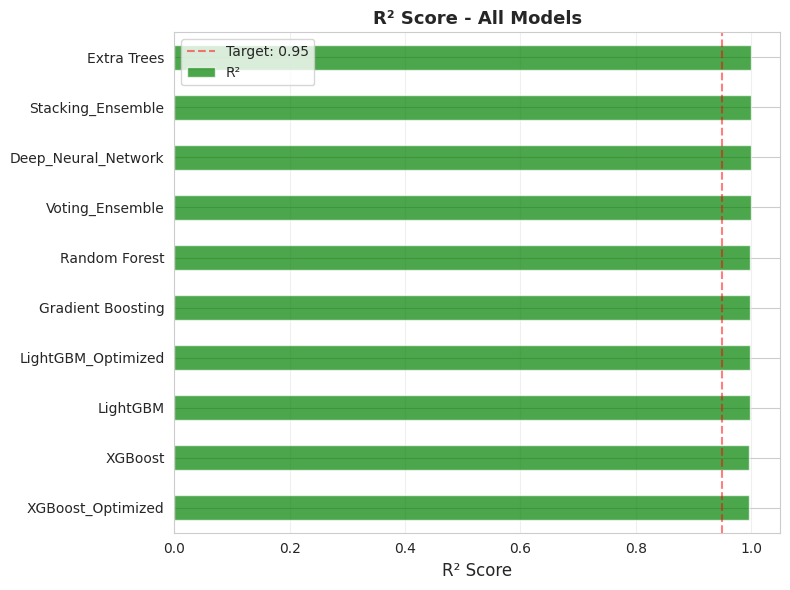

In [110]:
#  R² Comparison Across All Models
plt.figure(figsize=(8, 6))
all_metrics_df['R²'].sort_values(ascending=True).plot(kind='barh', color='green', alpha=0.7)
plt.title('R² Score - All Models', fontweight='bold', fontsize=13)
plt.xlabel('R² Score')
plt.axvline(x=0.95, color='red', linestyle='--', alpha=0.5, label='Target: 0.95')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('final_r2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


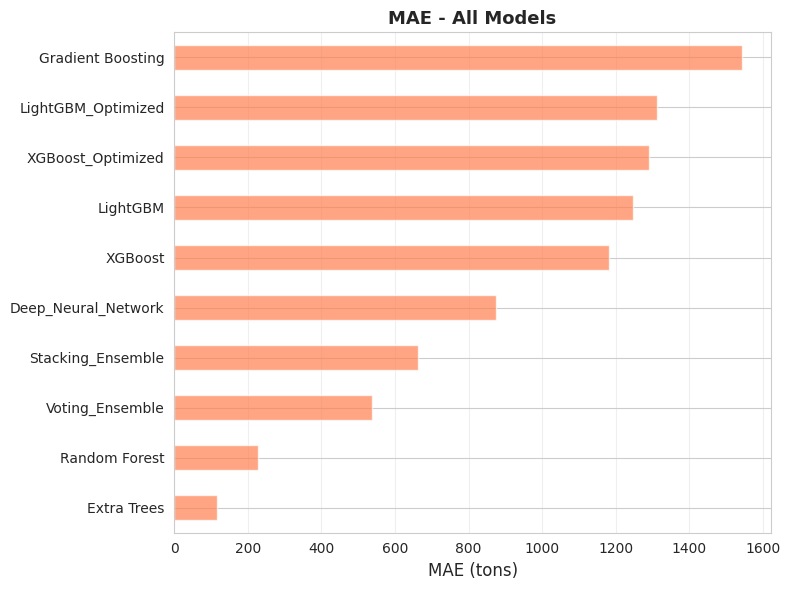

In [111]:
#  MAE Comparison Across All Models
plt.figure(figsize=(8, 6))
all_metrics_df['MAE'].sort_values().plot(kind='barh', color='coral', alpha=0.7)
plt.title('MAE - All Models', fontweight='bold', fontsize=13)
plt.xlabel('MAE (tons)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('final_mae_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


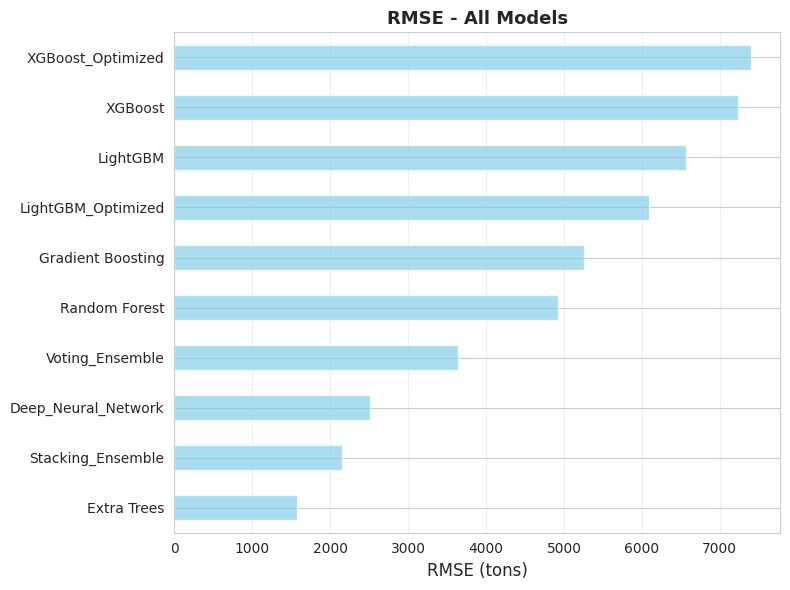

In [112]:
#  RMSE Comparison Across All Models
plt.figure(figsize=(8, 6))
all_metrics_df['RMSE'].sort_values().plot(kind='barh', color='skyblue', alpha=0.7)
plt.title('RMSE - All Models', fontweight='bold', fontsize=13)
plt.xlabel('RMSE (tons)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('final_rmse_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [113]:
for name, model in optimized_models.items():
    if name == 'Deep_Neural_Network':
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"{name}:  Train R² = {r2_train:.4f},  Test R² = {r2_test:.4f},  Gap = {r2_train - r2_test:.4f}")


XGBoost_Optimized:  Train R² = 0.9997,  Test R² = 0.9963,  Gap = 0.0035
LightGBM_Optimized:  Train R² = 0.9990,  Test R² = 0.9975,  Gap = 0.0015
Voting_Ensemble:  Train R² = 0.9997,  Test R² = 0.9991,  Gap = 0.0006
Stacking_Ensemble:  Train R² = 0.9999,  Test R² = 0.9997,  Gap = 0.0002
Deep_Neural_Network:  Train R² = 0.9997,  Test R² = 0.9996,  Gap = 0.0001


#STEP 12: SAVING BEST MODEL

In [114]:
import joblib

In [115]:
# Save the best-performing model
model_filename = f'best_model_{best_model_name.replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)
print(f"✅ Best model saved as: {model_filename}")

# Save the feature scaler
scaler_filename = 'feature_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler saved as: {scaler_filename}")

# Save feature column names
feature_filename = 'feature_names.pkl'
joblib.dump(feature_cols, feature_filename)
print(f"✅ Feature names saved as: {feature_filename}")


✅ Best model saved as: best_model_Stacking_Ensemble.pkl
✅ Scaler saved as: feature_scaler.pkl
✅ Feature names saved as: feature_names.pkl


In [116]:

print(" PROJECT COMPLETE! ALL ANALYSES SAVED SUCCESSFULLY!")

print("\n Summary of Generated Files:")
print("   1. comprehensive_eda.png")
print("   2. correlation_heatmap_enhanced.png")
print("   3. baseline_model_comparison.png")
print("   4. feature_importance_top15.png")
print("   5. comprehensive_model_evaluation.png")
print("   6. error_analysis.png")
print("   7. feature_importance_advanced.png")
print("   8. final_model_comparison_all.png")
print(f"   9. {model_filename}")
print(f"   10. {scaler_filename}")
print(f"   11. {feature_filename}")


 PROJECT COMPLETE! ALL ANALYSES SAVED SUCCESSFULLY!

 Summary of Generated Files:
   1. comprehensive_eda.png
   2. correlation_heatmap_enhanced.png
   3. baseline_model_comparison.png
   4. feature_importance_top15.png
   5. comprehensive_model_evaluation.png
   6. error_analysis.png
   7. feature_importance_advanced.png
   8. final_model_comparison_all.png
   9. best_model_Stacking_Ensemble.pkl
   10. feature_scaler.pkl
   11. feature_names.pkl


In [117]:
print("\n FINAL RESULTS:")
print(f"   Best Model: {best_model_name}")
print(f"   R² Score: {final_metrics[best_model_name]['R²']:.4f}")
print(f"   MAE: {final_metrics[best_model_name]['MAE']:,.2f} tons")
print(f"   RMSE: {final_metrics[best_model_name]['RMSE']:,.2f} tons")
print(f"   MAPE: {final_metrics[best_model_name]['MAPE']:.2f}%")

print("\n project is now complete with advanced features!")




 FINAL RESULTS:
   Best Model: Stacking_Ensemble
   R² Score: 0.9997
   MAE: 662.97 tons
   RMSE: 2,150.53 tons
   MAPE: 1315594869900448512.00%

 project is now complete with advanced features!
